## Optimization  

# Stochastic Optimization

    Authors: Jesús Cid-Sueiro
    Version: 1.0, Apr. 2020.

### Write your data here:

#### Name and NIA:  Leandro Hidalgo - 100391000
#### Name and NIA: Ignacio Serrano - 100418944

## Exercise: a comparative analysis of stochastic optimization algorithms

The goal of this exercise is to implement and test several stochastic optimization algorithms for the minimization of a given function. Gradient descent and Newton's method will be explored.

 1. Stochastic gradien descent (SGD)
 2. Minibatch-SGD
 3. Momentum
 4. Adagrad
 5. RMSprop
 6. Adadelta
 7. Adam or Yogi.

You can find an excellent description of these algorithms in **chapter 11** of

 - Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2019). [Dive into Deep Learning](http://d2l.ai/chapter_optimization/index.htm).

There you can find the updating equations of the algorithms, as well as useful fragments of python code for an implementation *from scratch*.

For this lab session you are not allowed to use available implementations of the algorithms. You can take code from the reference above if needed, but your code cannot call external libraries to carry out the optimization steps.

You can use external libraries to carry out other parts of the process, though, if needed.

You are requested to carry out a comparative analysis of these algorithms in a particular data analysis problem. To do so, you will need to define your case study.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy.utilities.lambdify import lambdify
from sympy import *
from sympy import Identity
import math
import warnings
warnings.filterwarnings('ignore')

### 1. Case study

Select your case study, by specifying a dataset and an optimization problem defined over this data.

We propose here one **default proposal**. Solving the lab exercise with the default proposal scores up to 8 out of 10 points. Choosing a different study (dataset and optimization problem), scores up to 2 more extra points.

#### Dataset proposal: 

The [Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) from the UCI machine learning repository, which is also available in the `sklearn` library:

In [2]:
from sklearn.datasets import load_breast_cancer
X_dat, Y_dat = load_breast_cancer(return_X_y=True)
print(f"-- {X_dat.shape[0]} samples with dimension {X_dat.shape[1]}")
print(f"-- Y[0:10] = {Y_dat[:30]}")

-- 569 samples with dimension 30
-- Y[0:10] = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]


**Data Standardization

In [3]:
from sklearn.preprocessing import StandardScaler

X_dat = StandardScaler().fit_transform(X_dat)

In [4]:
# Intercept = np.ones((X_dat.shape[0],1))
# X_dat = np.concatenate((Intercept, X_dat),axis = 1) # Adding bias term
data = np.concatenate((X_dat, Y_dat[:, np.newaxis]),axis = 1)# [bias,features,class]

#### Optimization problem:

Fitting a logistic regression model by maximum likelihood. The objective function can thus be expressed as the non-negative likelihood function given by
\begin{align}
\text{f}({\bf w}) 
    &= \sum_{k=0}^{K-1} \text{f}_0({\bf w}, {\bf x}_k, y_k) 
    \end{align}
where
\begin{align}
\text{f}_0({\bf w}, {\bf x}, {\bf y}) 
    &= \log\left[1+\exp\left(-(2y-1){\bf w}^\intercal {\bf x}\right)\right]
\end{align}

The gradient descent rule for this problem is well known:
\begin{align}
{\bf w}_{n+1} &= {\bf w}_n 
    + \rho_n {\bf X}^\top \left({\bf y}-\hat{\bf p}_n\right)
\end{align}
where
\begin{align}
{\bf y} &= [y_0,\ldots,y_{K-1}]^\top \\
\hat{\bf p}_n &= [g({\bf w}_n^\top {\bf z}_0), \ldots, g({\bf w}_n^\top {\bf z}_{K-1})]^\top
\end{align}
and $g$ is the logistic function
\begin{align}
g(t) = \frac{1}{1+e^{-t}}
\end{align}

#### Recommendations

Solve the whole lab exercise using the default case study. After date, and depending on your time availability, you can afford the application to another case study. 

If your code is modular enough, changing the case study should imply modifying the methods computing the objective function and the stochastic gradient.

- **Changing the dataset**: do not select very large datasets. You can simplfy public datasets by resampling or selecting features to make the problem smaller.

- **Selecting the objective function**: logistic regression is a well-behaved convex optimization problem. Other optimization problems, specially if they are not convex, may show more differences between algorithms, so they could be more interesting to play with. The selection, in any case, is free.

Take into account that the goal of this notebook is to analyze de behavior of the algorithms as optimizers of specific objective functions. This is not a machine learning exercise: **do not split the data into training and test sets**. You do not need to evaluate generalization capabilities of the model. Only need a training set is required, and the performance will be evaluated over the same training set.

### 2: The function and its derivatives.

Define separate methods to compute the function and the stochastic gradient:

* Method **`f`**: given ${\bf w}$, it returns the value of function $f({\bf w})$.
* Method **`df0k`**: given ${\bf w}$ and sample $({\bf x}, y)$, it returns the gradient of $f_0$ at (${\bf w}, {\bf x}, y)$

Recommendation: since you have the main equations for logistic regression in this notebook, you can start defining metods for the default case. Once you have completed the code for the default case, you can go back to this section, and replace these methods by the ones requiere for your case study.

In [5]:
N = X_dat.shape[1]
K = len(Y_dat)

# y, w, x = symbols('y w x', real=True)
# var = Matrix([y,w,x]) # Jacobian

Y = MatrixSymbol('Y',1,1)
X = MatrixSymbol('X',N,1)
W = MatrixSymbol('W',N,1)

# #Function
f_0 = Matrix([log(1 + exp(-1*(2*Y-1*Identity(1))*W.T*X))]) # for fucntion
# f_1 = Matrix([log(1 + exp(-1*(2*y-1)*MatMul(w,x)))])  # for derivative
# # f =  sum(f_0)

# Funcion f
# <SOL>

f_0 = lambdify([Y,W,X], f_0)

def f(w):
    f_w = 0
    for i in range(K):
        x_dat = data[i,:-1].reshape(N,1)
        y_dat = data[i,-1].reshape(1,1)
        f_w = np.squeeze(f_0(y_dat,w,x_dat))
    return f_w
        
# </SOL>

# First derivative
# <SOL>
# df0 = f_1.diff(w) # We used symbolic to compute the gradient expression

def df0k(ws,xs,ys):
    return (xs*(1-2*ys)*np.exp(ws.T*xs*(1-2*ys)))/(np.exp(ws.T*xs*(1-2*ys))+1)
# </SOL>

# # Second derivative
# # <SOL>
# d2f = lambdify(w, d2f)
# </SOL>

### 3: The algorithms

Implement a method computing a single iterationn of each optimization algorithm.

The input and outputs for each method will depend on the algorith. The input should contain the current model parameters or state vectors, and the current data input (batch of inputs, in the minibatch case). Send method `df0k` as parameter too. This way, you can solve the lab exercise using the default case study, and defer the changes of dataset and optimization function to the end.

In [6]:
def logistic(t):
    return 1/(1 + np.exp(-t))

In [7]:
def sgd_LR(params,sample,lr):
    
    for i in range(len(params)):
        
        params[i] = params[i] + (lr * (sample[-1] - logistic(params.T@sample[:-1]))*sample[i])
        
    return params

In [8]:
def adadelta(params, sample, states, deltas, lr, df):
    eps= 1e-5
    
    for i,p in enumerate(params):
        grad = df(p,sample[i],sample[-1])
        
        states[i] = lr * states[i] + (1. - lr) * grad**2
        cur_delta = np.sqrt(deltas[i] + eps) / np.sqrt(states[i] + eps) * grad
        
        deltas[i] = lr * deltas[i] + (1. - lr) * cur_delta**2
        
        params[i] = p - cur_delta
        
    return params, states, deltas

In [9]:
def adam(params, sample, lr, velocity, states, t, df):
    
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-6
    
    for i, p in enumerate(params):
        
        grad = df(p,sample[i],sample[-1])
        
        velocity[i] = beta1 * velocity[i] + (1 - beta1) * grad
        states[i] = states[i] + (1 - beta2) * np.sign(grad**2-states[i])*grad**2
        
        v_bias_corr = velocity[i] / (1 - beta1 ** t)
        s_bias_corr = states[i] / (1 - beta2 ** t)
        
        div = lr * v_bias_corr / (np.sqrt(s_bias_corr) + eps_stable)
        
        params[i] = p - div
        
    t += 1
    
    return params, t, states, velocity

In [10]:
def momentum(params, sample, lr, velocity, df):
    beta = 0.9
  
    for i, (p, v) in enumerate(zip(params, velocity)):
            
        grad = df(p,sample[i],sample[-1])
        velocity[i] = beta * v + lr * grad
        params[i] -= velocity[i]

    return params, velocity

In [11]:
def adagrad(params, sample, lr, states, df):
    
    eps = 1e-6
    
    for i, (p, s) in enumerate(zip(params, states)):
         
        grad = df(p,sample[i],sample[-1])
        states[i] += np.square(grad) 
        params[i] -= lr * grad / np.sqrt(s + eps)
    
    return params, states

In [12]:
def rmsprop(params, sample, lr, states, df):
  
    # <SOL>
    eps=1e-6
    gamma = 0.2
    
    for i, (p, s) in enumerate(zip(params, states)):
         
        grad = df(p,sample[i],sample[-1])
        states[i] = gamma*s + (1-gamma)*grad**2
        params[i] = p - lr / sqrt(s + eps) * grad

    return params, states

**-------------------------------------------------------------------------------------------------------------------**

### 4: The comparative analysis.

Try to make a comparative analysis of the behaviour of these algorithms in your case study. To do so, make two kind of plots:

 1. Algorithm performance after a fixed number of steps, as a function of the free parameters of each algorithm.
 2. Convergence of the algorithm with time.

For the second type of plots, you will have to face the problem of selecting the value of the learning step. Try to make a fair choice that does not bias the result in favor of a specific algorithm. One option is, for instance, to take the best values according to the first type of plots.


#### 1. Algorithm performance after a fixed number of steps, as a function of the free parameters of each algorithm.or of a specific algorithm

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
# Make a prediction with coefficients
def predict(row, coefficients):
    yhat = 0
    for i in range(len(row)):
        yhat += coefficients[i] * row[i]
    return 1/(1 + np.exp(-yhat))

In [15]:
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

In [16]:
# Parameters initialization
num_epochs = 25
params_init =  np.zeros((30,1))

t_val = 1
lr = 0.0001

s = np.zeros((len(params_init),1))
v = np.zeros((len(params_init),1))
d = np.zeros((len(params_init),1))

In [17]:
params_sgd = np.random.uniform(-1,1,size =(30,1))
params_adadelta = np.random.uniform(-1,1,size =(30,1))
params_adam = np.random.uniform(-1,1,size =(30,1))
params_momentum = np.random.uniform(-1,1,size =(30,1))
params_adagrad = np.random.uniform(-1,1,size =(30,1))
params_rms = np.random.uniform(-1,1,size =(30,1))

s_adadelta = s
s_adam = s
s_adagrad = s
s_rmsprop = s

v_adam = v
v_momentum = v

d_adadelta = d


sum_error_sgd = []
sum_error_adadelta = []
sum_error_adam = []
sum_error_momentum = []
sum_error_adagrad = []
sum_error_rms = []

acc_sgd = []
acc_adadelta = []
acc_adam = []
acc_momentum = []
acc_adagrad = []
acc_rms = []

In [18]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_sgd = []    
    y_true = []
    
    error = 0
    
    for _, dat in enumerate(data):
        
        pred_sgd.append(np.round(predict(dat[:-1],params_sgd)))        
        y_true.append(dat[-1])
        
        error += square_loss(dat[-1], pred_sgd[-1])
        
        params_sgd = sgd_LR(params_sgd,dat,lr)
        
    sum_error_sgd.append(error)    
    acc_sgd.append(accuracy_score(y_true, pred_sgd))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


In [19]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_adadelta = []    
    y_true = []
    
    error = 0 
    
    for _, dat in enumerate(data):
        
        pred_adadelta.append(np.round(predict(dat[:-1],params_adadelta)))
        y_true.append(dat[-1])
        
        error += square_loss(dat[-1], pred_adadelta[-1])
        
        params_adadelta, s_adadelta, d_adadelta = adadelta(params_adadelta, dat, s_adadelta, d_adadelta, lr, df0k)
        
    sum_error_adadelta.append(error)
    acc_adadelta.append(accuracy_score(y_true, pred_adadelta))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


In [20]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_adam = []    
    y_true = []
    
    error = 0
    
    for _, dat in enumerate(data):
        
        pred_adam.append(np.round(predict(dat[:-1],params_adam)))        
        y_true.append(dat[-1])
        
        error += square_loss(dat[-1], pred_adam[-1])
        
        params_adam, t_val, s_adam, v_adam = adam(params_adam, dat, lr, v_adam, s_adam, t_val, df0k)
    
    sum_error_adam.append(error)
    acc_adam.append(accuracy_score(y_true, pred_adam))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


In [21]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_momentum = []    
    y_true = []
    
    error = 0
    
    for _, dat in enumerate(data):
        
        pred_momentum.append(np.round(predict(dat[:-1],params_momentum)))
        y_true.append(dat[-1])
        
        error += square_loss(dat[-1], pred_momentum[-1])
        
        params_momentum, v_momentum = momentum(params_momentum, dat, lr, v_momentum, df0k)
        
    sum_error_momentum.append(error)    
    acc_momentum.append(accuracy_score(y_true, pred_momentum))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


In [22]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_adagrad = []    
    y_true = []
    
    error = 0
    
    for _, dat in enumerate(data):
        
        pred_adagrad.append(np.round(predict(dat[:-1],params_adagrad)))        
        y_true.append(dat[-1])
        
        error += square_loss(dat[-1], pred_adagrad[-1])
        
        params_adagrad, s_adagrad = adagrad(params_adagrad, dat, lr, s_adagrad, df0k)
    
    sum_error_adagrad.append(error)
    acc_adagrad.append(accuracy_score(y_true, pred_adagrad))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


In [23]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_rmsprop = []
    
    y_true = []
    
    error = 0
    
    for _, dat in enumerate(data):
        
        pred_rmsprop.append(np.round(predict(dat[:-1],params_rms)))        
        y_true.append(dat[-1])
        
        error += square_loss(dat[-1], pred_rmsprop[-1])
        
        params_rms, s_rmsprop = rmsprop(params_rms, dat, lr, s_rmsprop, df0k)
        
    sum_error_rms.append(error)
    acc_rms.append(accuracy_score(y_true, pred_rmsprop))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


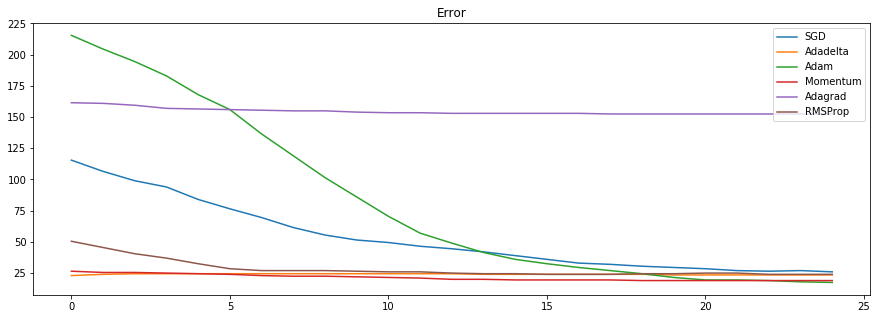

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(sum_error_sgd, label = 'SGD')
plt.plot(sum_error_adadelta, label = 'Adadelta')
plt.plot(sum_error_adam, label = 'Adam')
plt.plot(sum_error_momentum, label = 'Momentum')
plt.plot(sum_error_adagrad, label = 'Adagrad')
plt.plot(sum_error_rms, label = 'RMSProp')
plt.title('Error')
plt.legend()

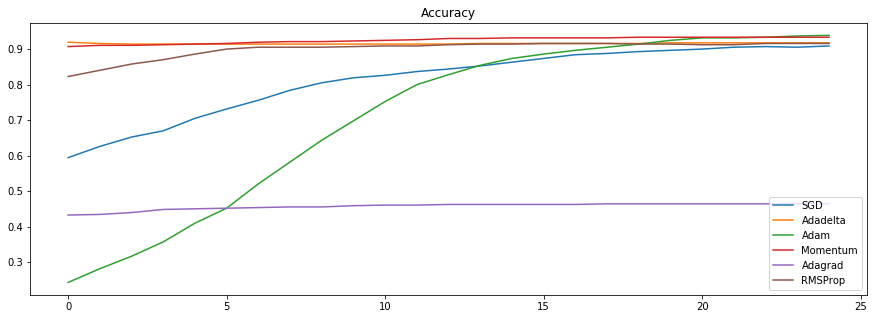

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(acc_sgd, label = 'SGD')
plt.plot(acc_adadelta, label = 'Adadelta')
plt.plot(acc_adam, label = 'Adam')
plt.plot(acc_momentum, label = 'Momentum')
plt.plot(acc_adagrad, label = 'Adagrad')
plt.plot(acc_rms, label = 'RMSProp')
plt.title('Accuracy')
plt.legend()

In the first plot, we can observe how  the accuracy increases in time, except on Adadelta and Momentum, this is due to the parameter initialization, that was closer to the minimum than the other weights. Also, we can see hoy Adagrad does not reach a good accuracy in 25 epochs, this is probably because the LR, which is common for all algorithms, is not the optimal for Adagrad.

On the other hand, we can see the squared error in the second plot. In time, this error decreases, what makes us deduce that the algorithm improves. When the error (i.e., number of missclassifications) don't vary much, means the algorithm is converging.

We will see in the next part, how a good LR per algorithm outperforms this actual approximation.

#### 2. Convergence of the algorithm with time.

In [26]:
# Parameters initialization
num_epochs = 25
params_init =  np.zeros((30,1))

t_val = 1
lr = 0.0001

s = np.zeros((len(params_init),1))
v = np.zeros((len(params_init),1))
d = np.zeros((len(params_init),1))

params_sgd = np.random.uniform(-1,1,size =(30,1))
params_adadelta = np.random.uniform(-1,1,size =(30,1))
params_adam = np.random.uniform(-1,1,size =(30,1))
params_momentum = np.random.uniform(-1,1,size =(30,1))
params_adagrad = np.random.uniform(-1,1,size =(30,1))
params_rms = np.random.uniform(-1,1,size =(30,1))

s_adadelta = s
s_adam = s
s_adagrad = s
s_rmsprop = s

v_adam = v
v_momentum = v

d_adadelta = d

sum_error_sgd_2 = []
sum_error_adadelta_2 = []
sum_error_adam_2 = []
sum_error_momentum_2 = []
sum_error_adagrad_2 = []
sum_error_rms_2 = []

acc_sgd_2 = []
acc_adadelta_2 = []
acc_adam_2 = []
acc_momentum_2 = []
acc_adagrad_2 = []
acc_rms_2 = []

In [27]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_sgd = []    
    y_true = []
    
    error = 0
    
    for _, dat in enumerate(data):
        
        pred_sgd.append(np.round(predict(dat[:-1],params_sgd)))        
        y_true.append(dat[-1])
        
        error += square_loss(dat[-1], pred_sgd[-1])
        
        params_sgd = sgd_LR(params_sgd,dat,0.1)
        
    sum_error_sgd_2.append(error)    
    acc_sgd_2.append(accuracy_score(y_true, pred_sgd))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


In [28]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_adadelta = []    
    y_true = []
    
    error = 0
    
    for _, dat in enumerate(data):
        
        pred_adadelta.append(np.round(predict(dat[:-1],params_adadelta)))
        y_true.append(dat[-1])
        
        error += square_loss(dat[-1], pred_adadelta[-1])
        
        params_adadelta, s_adadelta, d_adadelta = adadelta(params_adadelta, dat, s_adadelta, d_adadelta, 0.9, df0k)
        
    sum_error_adadelta_2.append(error)
    acc_adadelta_2.append(accuracy_score(y_true, pred_adadelta))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


In [29]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_adam = []    
    y_true = []
    
    error = 0
    
    for _, dat in enumerate(data):
        
        pred_adam.append(np.round(predict(dat[:-1],params_adam)))        
        y_true.append(dat[-1])
        
        error += square_loss(dat[-1], pred_adam[-1])
        
        params_adam, t_val, s_adam, v_adam = adam(params_adam, dat, 0.01, v_adam, s_adam, t_val, df0k)
    
    sum_error_adam_2.append(error)
    acc_adam_2.append(accuracy_score(y_true, pred_adam))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


In [30]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_momentum = []    
    y_true = []
    
    error = 0
    
    for _, dat in enumerate(data):
        
        pred_momentum.append(np.round(predict(dat[:-1],params_momentum)))
        y_true.append(dat[-1])
        
        error += square_loss(dat[-1], pred_momentum[-1])
        
        params_momentum, v_momentum = momentum(params_momentum, dat, 0.4, v_momentum, df0k)
        
    sum_error_momentum_2.append(error)    
    acc_momentum_2.append(accuracy_score(y_true, pred_momentum))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


In [31]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_adagrad = []    
    y_true = []
    
    error = 0 
    
    for _, dat in enumerate(data):
        
        pred_adagrad.append(np.round(predict(dat[:-1],params_adagrad)))        
        y_true.append(dat[-1])
        
        error += square_loss(dat[-1], pred_adagrad[-1])
        
        params_adagrad, s_adagrad = adagrad(params_adagrad, dat, 0.4, s_adagrad, df0k)
    
    sum_error_adagrad_2.append(error)
    acc_adagrad_2.append(accuracy_score(y_true, pred_adagrad))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


In [32]:
for e in range(num_epochs):
        
    print('Epoch ', e)
    np.random.shuffle(data)
    
    pred_rmsprop = []
    
    y_true = []
    
    error = 0
    
    for _, dat in enumerate(data):
        
        pred_rmsprop.append(np.round(predict(dat[:-1],params_rms)))        
        y_true.append(dat[-1])        
        
        error += square_loss(dat[-1], pred_rmsprop[-1])
        
        params_rms, s_rmsprop = rmsprop(params_rms, dat, 0.4, s_rmsprop, df0k)
        
    sum_error_rms_2.append(f(params_rms))
    acc_rms_2.append(accuracy_score(y_true, pred_rmsprop))

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24


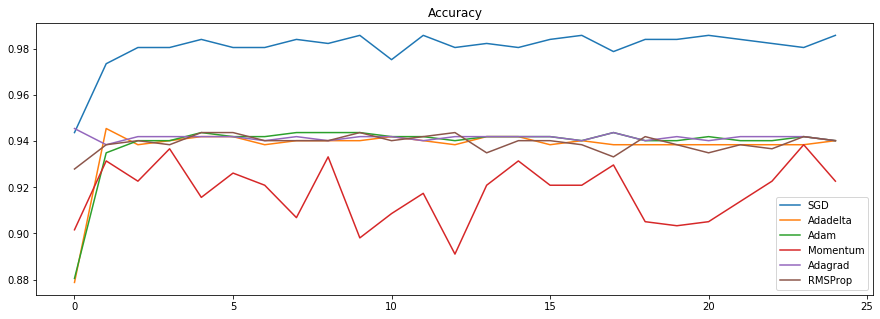

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(acc_sgd_2, label = 'SGD')
plt.plot(acc_adadelta_2, label = 'Adadelta')
plt.plot(acc_adam_2, label = 'Adam')
plt.plot(acc_momentum_2, label = 'Momentum')
plt.plot(acc_adagrad_2, label = 'Adagrad')
plt.plot(acc_rms_2, label = 'RMSProp')
plt.title('Accuracy')
plt.legend()

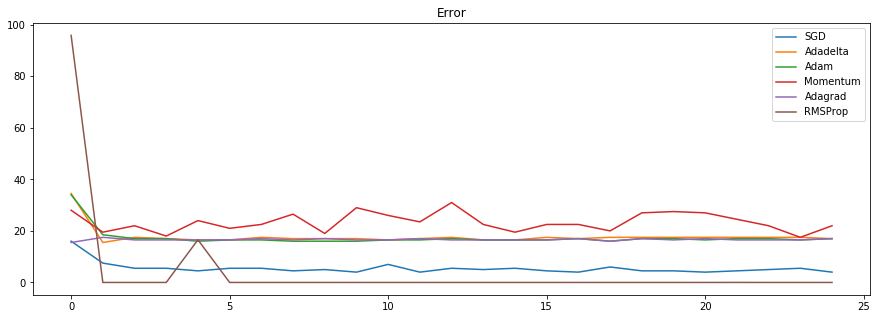

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(sum_error_sgd_2, label = 'SGD')
plt.plot(sum_error_adadelta_2, label = 'Adadelta')
plt.plot(sum_error_adam_2, label = 'Adam')
plt.plot(sum_error_momentum_2, label = 'Momentum')
plt.plot(sum_error_adagrad_2, label = 'Adagrad')
plt.plot(sum_error_rms_2, label = 'RMSProp')
plt.title('Error')
plt.legend()

As we expected, with a personalized weight initialization of the LR, all algorithms perform much better than before, reaching a good accuracy quicker than before.

Also, the squared error is stable in time since the parameters are optimized for this problem.